In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder

In [128]:
df = pd.read_csv("train.csv", parse_dates=['date'])
df.set_index('date', inplace=True)

In [129]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)

<Axes: xlabel='date'>

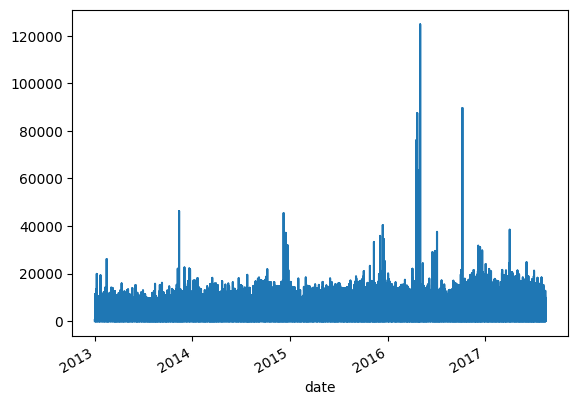

In [130]:
sales = df['sales']
sales.plot()

In [131]:
# Sort and group
df = df.sort_values(['store_nbr', 'family'])

group_cols = ['store_nbr', 'family']
g = df.groupby(group_cols)['sales']


for d in [1, 7, 14, 28, 56]:
    df[f'lag_{d}'] = g.shift(d)


for w in ['7D', '14D']:
    name = f'rolling_{w[:-1]}_mean'
    df[name] = (
        g.apply(lambda s: s.shift(1).rolling(w).mean())
          .reset_index(level=group_cols, drop=True)
    )

# Explore the data of holidays.csv to see if we can get some useful features

In [132]:
holidays = pd.read_csv('holidays_events.csv', parse_dates=['date'])
holidays.set_index('date', inplace=True)

In [133]:
num_holidays = len(holidays['description'].unique())

# Let's merge df with holidays on the index col 'date'

In [134]:
df = (
    df
    .reset_index()
    .merge(
        holidays.reset_index(),
        on="date",
        how="left"
    )
    .set_index("date")
)

In [135]:
df['is_holiday'] = df['type'].notna().astype(int)

In [136]:
holiday_col = df.pop('is_holiday')
pos = df.columns.get_loc('rolling_14_mean')
df.insert(pos+1, 'is_holiday', holiday_col)

In [137]:
df['transferred'] = df['transferred'].fillna(0).astype(int)

In [138]:
cols = ['type','locale','locale_name','description']
df[cols] = df[cols].fillna('NO_HOLIDAY')

In [139]:
def encode_columns(df, columns, placeholder="NO_HOLIDAY"):
    for col in columns:
        mask = df[col] == placeholder

        le = LabelEncoder()
        le.fit(df.loc[~mask, col].astype(str))

        df.loc[~mask, col] = le.transform(df.loc[~mask, col].astype(str)) + 1

        df.loc[mask, col] = 0

        df[col] = df[col].astype(int)

    return df

In [140]:
cols = ['type','locale','locale_name','description']
df[cols] = df[cols].fillna('NO_HOLIDAY')

In [141]:
df = encode_columns(df, cols)

In [142]:
lag_rolling_cols = [
    'lag_1', 'lag_7', 'lag_14', 'lag_28', 'lag_56',
    'rolling_7_mean', 'rolling_14_mean'
]
df = df.dropna(subset=lag_rolling_cols)

In [143]:
df.head()

,id,store_nbr,family,sales,onpromotion,year,month,day,dayofweek,is_weekend,...,lag_28,lag_56,rolling_7_mean,rolling_14_mean,is_holiday,type,locale,locale_name,description,transferred
date,,,,,,,,,,,,,,,,,,,,,
2013-02-26,99792,1,AUTOMOTIVE,0.0,0,2013,2,26,1,0,...,2.0,0.0,2.000000,1.285714,0,0,0,0,0,0
2013-02-27,101574,1,AUTOMOTIVE,2.0,0,2013,2,27,2,0,...,6.0,2.0,1.428571,1.285714,0,0,0,0,0,0
2013-02-28,103356,1,AUTOMOTIVE,1.0,0,2013,2,28,3,0,...,0.0,3.0,1.428571,1.428571,0,0,0,0,0,0
2013-03-01,105138,1,AUTOMOTIVE,2.0,0,2013,3,1,4,0,...,3.0,3.0,1.428571,1.500000,0,0,0,0,0,0
2013-03-02,106920,1,AUTOMOTIVE,1.0,0,2013,3,2,5,1,...,0.0,5.0,1.428571,1.642857,1,4,1,16,26,0


In [144]:
df.index.min(), df.index.max()

(Timestamp('2013-02-26 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [145]:
cutoff_date = "2017-07-15"

In [146]:
train_df = df[df.index < cutoff_date]
val_df   = df[df.index >= cutoff_date]

In [147]:
X_train = train_df.drop(['sales', 'id', 'family'], axis=1)
y_train = train_df['sales']

In [148]:
X_val = val_df.drop(['sales', 'id', 'family'], axis=1)
y_val = val_df['sales']

In [149]:
from xgboost import XGBRegressor
model = XGBRegressor(
    n_estimators = 300,
    learning_rate = 0.1,
    max_depth = 7,
    reg_alpha = 0,
    reg_lambda = 0.5,
    subsample = 1.0,
    colsample_bytree = 0.8,
    random_state = 42,
    verbosity = 0,
    tree_method      = "gpu_hist"
)

In [150]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [151]:
y_fit  = model.predict(X_train)
y_pred = model.predict(X_val)

In [152]:
mae = mean_absolute_error(y_train, y_fit)

print(f"Training MAE: {mae:.2f}")

Training MAE: 42.21


In [153]:
test_mae = mean_absolute_error(y_val, y_pred)
print(f"Test MAE: {test_mae:.2f}")

Test MAE: 58.49


In [163]:
model = XGBRegressor(
    n_estimators = 1000,
    learning_rate = 0.1,
    max_depth = 7,
    reg_alpha = 0,
    reg_lambda = 0.5,
    subsample = 1.0,
    colsample_bytree = 0.8,
    random_state = 42,
    verbosity = 0,
    tree_method = "gpu_hist",
    early_stopping_rounds = 50
)

In [164]:
model.fit(X_train, y_train,
          eval_set = [(X_train, y_train), (X_val, y_val)],
          verbose = True)

[0]	validation_0-rmse:1012.30674	validation_1-rmse:1165.41086
[1]	validation_0-rmse:920.38407	validation_1-rmse:1050.71397
[2]	validation_0-rmse:837.81884	validation_1-rmse:948.01217
[3]	validation_0-rmse:764.39429	validation_1-rmse:856.72534
[4]	validation_0-rmse:699.08870	validation_1-rmse:773.94158
[5]	validation_0-rmse:640.95298	validation_1-rmse:700.61605
[6]	validation_0-rmse:589.15200	validation_1-rmse:635.04381
[7]	validation_0-rmse:543.28706	validation_1-rmse:576.67727
[8]	validation_0-rmse:503.04617	validation_1-rmse:524.64361
[9]	validation_0-rmse:466.62775	validation_1-rmse:479.18602
[10]	validation_0-rmse:435.38240	validation_1-rmse:439.18990
[11]	validation_0-rmse:407.96447	validation_1-rmse:404.40831
[12]	validation_0-rmse:384.13034	validation_1-rmse:373.58354
[13]	validation_0-rmse:363.51733	validation_1-rmse:347.24513
[14]	validation_0-rmse:345.20773	validation_1-rmse:324.14894
[15]	validation_0-rmse:329.88923	validation_1-rmse:305.01577
[16]	validation_0-rmse:315.8337

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [167]:
from sklearn.metrics import mean_squared_log_error
rmsle = mean_squared_log_error(y_val, np.clip(y_pred, 0, None))
print(f"RMSLE: {rmsle:.4f}")

RMSLE: 0.2381


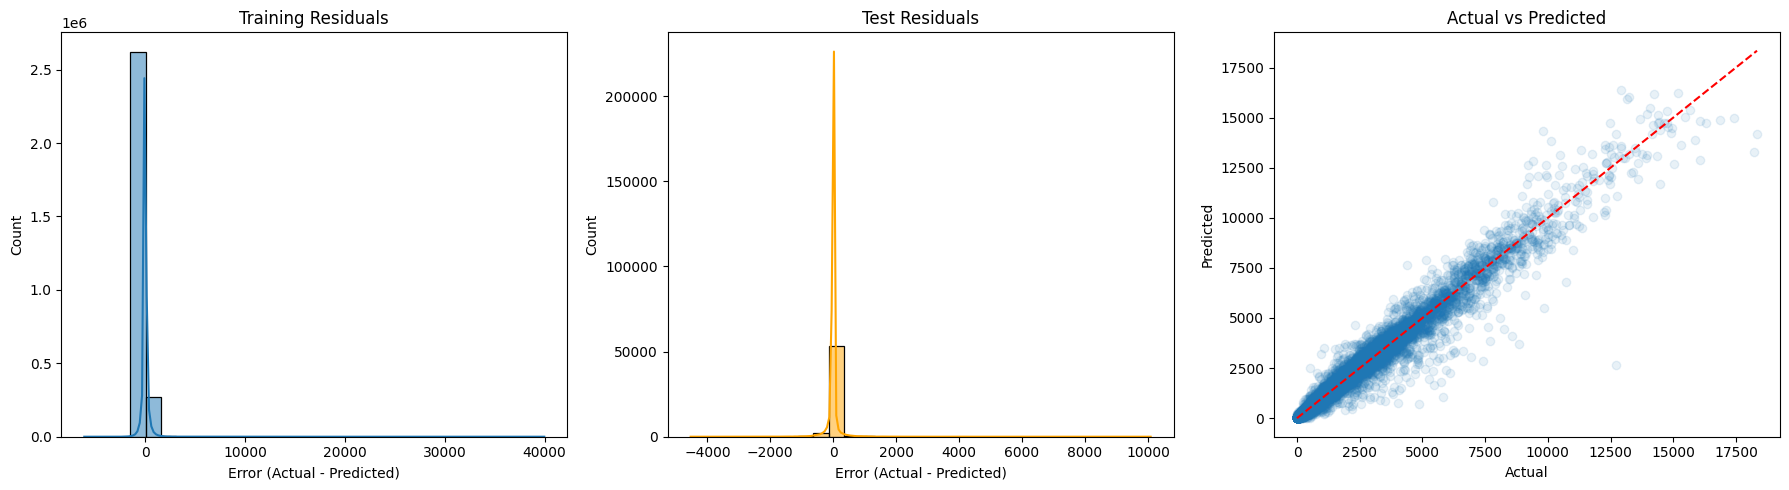

In [168]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(y_train - y_fit, bins=30, kde=True)
plt.title("Training Residuals")
plt.xlabel("Error (Actual - Predicted)")


plt.subplot(1, 3, 2)
sns.histplot(y_val - y_pred, bins=30, kde=True, color='orange')
plt.title("Test Residuals")
plt.xlabel("Error (Actual - Predicted)")


plt.subplot(1, 3, 3)
plt.scatter(y_val, y_pred, alpha=0.1)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")

plt.tight_layout()
plt.show()


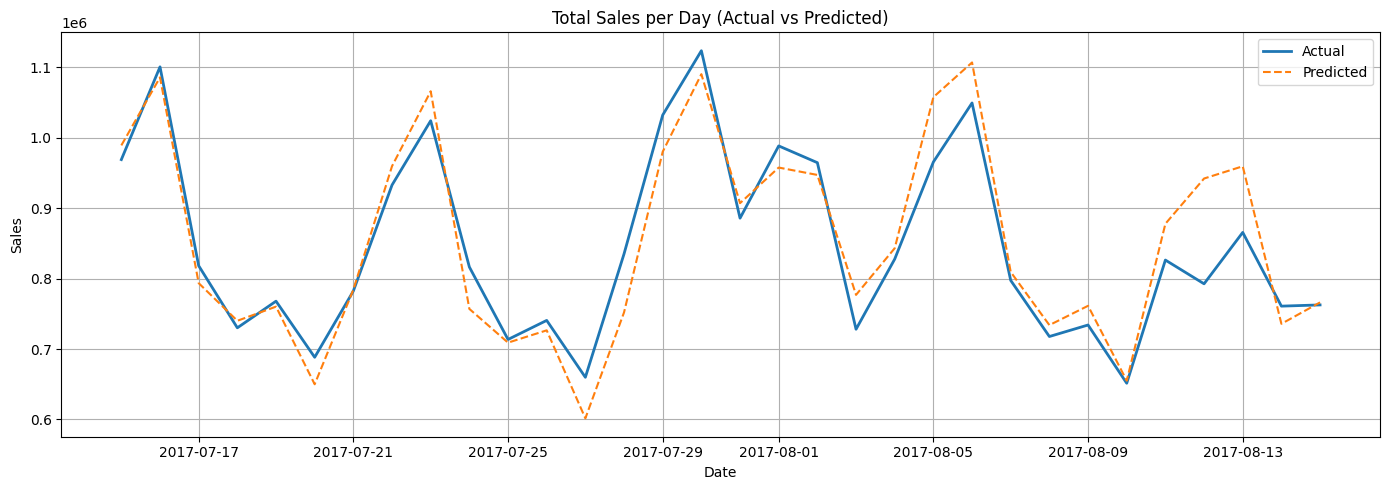

In [169]:
plot_df = val_df.copy()
plot_df["predicted"] = y_pred
plot_df["actual"] = y_val

# Group by date and sum to collapse across all store/family combos
daily = plot_df.groupby("date")[["actual", "predicted"]].sum()

# Plot
plt.figure(figsize=(14,5))
plt.plot(daily.index, daily["actual"], label="Actual", linewidth=2)
plt.plot(daily.index, daily["predicted"], label="Predicted", linestyle="--")
plt.title("Total Sales per Day (Actual vs Predicted)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()